# 3.1 Foundations of GANs: Adversarial training
## 3.1.1 Cost functions
- GANのcost functionと従来のneural networkのcost functionの区別：
 - 従来のcost function: $J(\theta)$。$\theta$は全部自分のパラメータ。
 - GANの２つcost functions: $J^{(D)}(\theta^{(G)},\theta^{(D)})$や$J^{(G)}(\theta^{(G)},\theta^{(D)})$は自分のパラメータだけじゃなく、相手のパラメータも含んでいる。

## 3.1.2 Training process
- Nash equilibrium（釣り合い、平衡）の例：車通勤
 - Nash equilibrium would occur when **every route home takes exactly the same amount of time** - for us and all other drivers we may encounter on the way.
     - この時だけ、ルートをどう変えても通勤時間は改善できない。
 - **Any faster route** would be **offset** by a **proportional increase in traffic**, slowing everyone down just the right amount.

# Step 1: Importing modules and specifying model input dimensions

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
# Size of the noise vector, used as input to the Generator.
z_dim = 100

# Step 2: the Generator
- 経験上の選び:
 - Leaky ReLU.
     - Leaky ReLU allows a small positive gradient. This prevents gradients from dying out during training, which tends to yield better training outcomes.
     - $f(x)=\alpha * x$ for $x<0$.
 - tanh.
     - tanh scales the output values to the range [-1,1]. tanh tends to produce crisper images.
 - Adam.
     - これは確かにDCGAN論文のアドバイス。

In [7]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    # Denseのinputが2Dだったら、shapeは(batch_size, input_dim)です。だからここはinput_dimだけ指定している。
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Step 3: the Discriminator
- In most GAN implementations, the Generator and Discriminator network architectures vary greatly in both size and complexity.

In [9]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Step 4: the GAN

In [10]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [12]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])
generator = build_generator(img_shape, z_dim)
# GAN(Generator)をトレーニングする時、Discriminatorのパラメータを変更しちゃだめ。
discriminator.trainable = False
gan = build_gan(generator=generator, discriminator=discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Step 5: GAN training loop
- Generatorのoutput画像のpixel valueは[-1,1]（tanhの結果）なので、mnistのpixelも[-1,1]にしている。
- GAN(Generator)をトレーニングの目標はDiscriminatorの**false positive**を最大化すること。
 - Discriminatorの目標は自分のtrue positiveやtrue negativeを最大化すること。
- Discriminatorのinputはbatch_size * img_shapeの画像。GANのinputはbatch_size * z_dimのランダムvector。

In [20]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0.0, 1.0, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    # Rescale image pixel values to [0,1] from [-1,1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(nrows=image_grid_rows,
                           ncols=image_grid_columns,
                           figsize=(4, 4),
                           sharex=True,
                           sharey=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [24]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    # Rescale [0,255] grayscale pixel values to [-1,1]
    X_train = X_train / 127.5 - 1.0
    # X_trainのshapeを(N*28*28)から(N*28*28*1)に変換。img_shapeに合わせるため。
    X_train = np.expand_dims(X_train, axis=3)
    
    # labelを用意する
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # Discriminatorの学習
        # Get a random batch of real images
        # randint(low, high, size)。duplicateあるかもしれない。
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        # Generate a batch of fake images
        # normal(loc=0.0, scale=1.0, size=None)
        z = np.random.normal(0.0, 1.0, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, real) # true positive
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # true negative
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Generatorの学習
        z = np.random.normal(0.0, 1.0, (batch_size, z_dim))
#         gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real) # false positive
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                 (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            # Output a sample of generated image
            sample_images(generator)

# Step 6: Train the GAN and Inspect output

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.048121, accuracy: 99.22%] [G loss: 5.474224]
2000 [D loss: 0.270375, accuracy: 90.23%] [G loss: 6.014719]
3000 [D loss: 0.244314, accuracy: 90.23%] [G loss: 4.878516]
4000 [D loss: 0.179640, accuracy: 93.36%] [G loss: 4.887496]
5000 [D loss: 0.213488, accuracy: 92.97%] [G loss: 5.768149]
6000 [D loss: 0.308029, accuracy: 87.89%] [G loss: 5.080084]
7000 [D loss: 0.299525, accuracy: 86.72%] [G loss: 3.834575]
8000 [D loss: 0.209301, accuracy: 91.80%] [G loss: 3.922490]
9000 [D loss: 0.336696, accuracy: 85.94%] [G loss: 4.904421]
10000 [D loss: 0.625822, accuracy: 75.78%] [G loss: 2.857159]
11000 [D loss: 0.499865, accuracy: 78.12%] [G loss: 2.578516]
12000 [D loss: 0.299428, accuracy: 88.28%] [G loss: 2.837397]
13000 [D loss: 0.280032, accuracy: 89.06%] [G loss: 3.793768]
14000 [D loss: 0.234126, accuracy: 91.02%] [G loss: 3.932060]
15000 [D loss: 0.485757, accuracy: 76.95%] [G loss: 2.667315]
16000 [D loss: 0.589069, accuracy: 76.17%] [G loss: 3.110996]
17000 [D loss: 0.

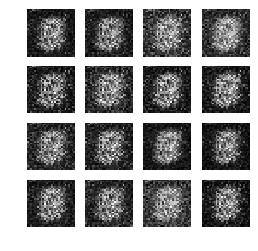

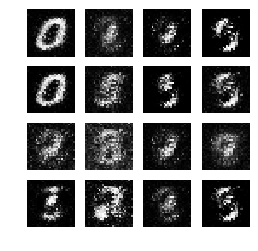

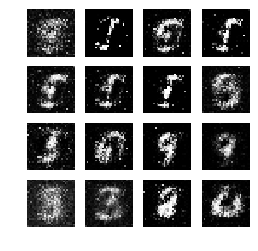

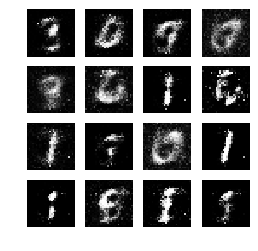

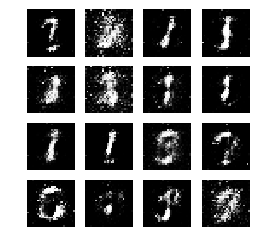

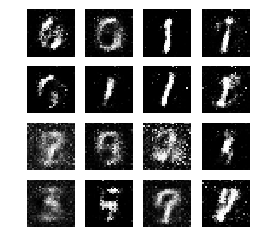

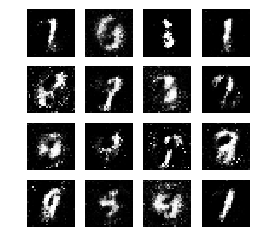

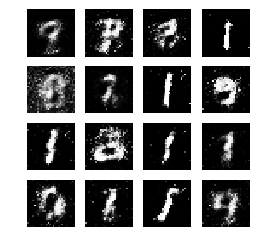

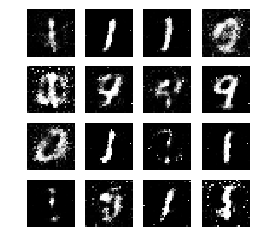

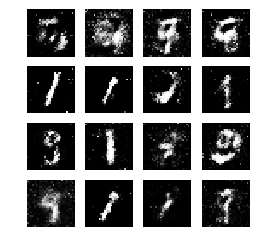

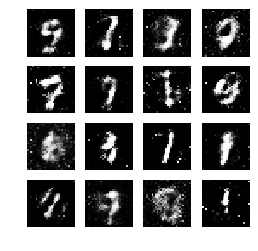

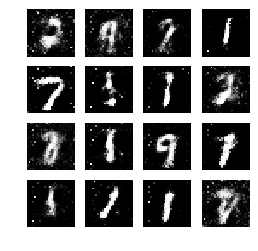

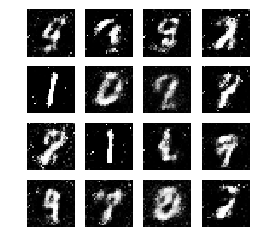

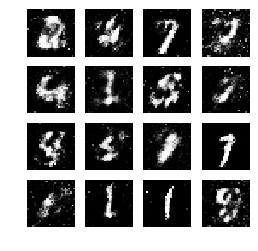

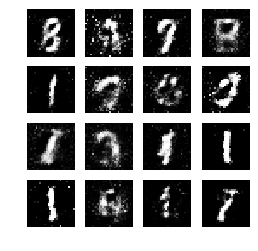

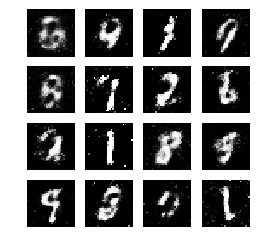

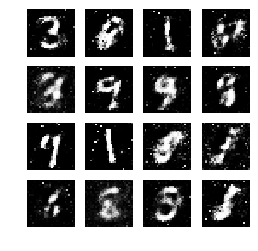

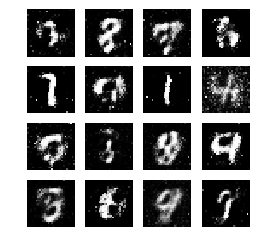

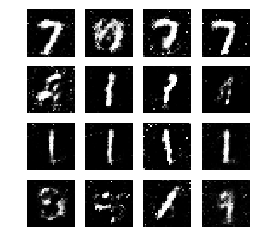

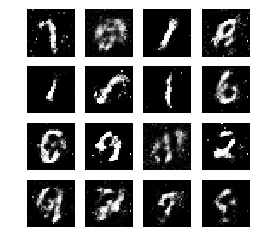

In [25]:
iterations = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)

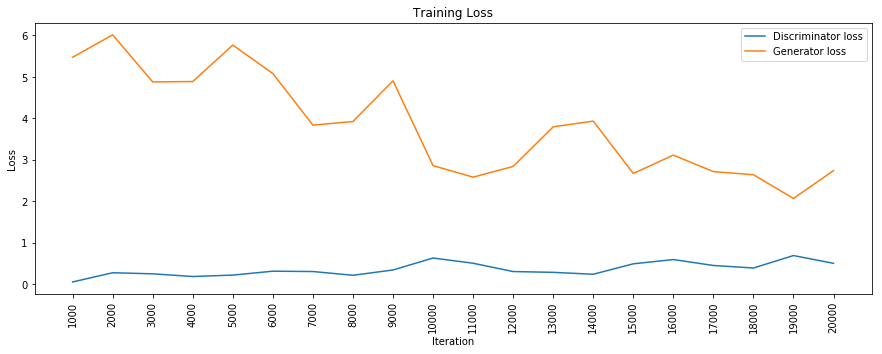

In [30]:
losses = np.array(losses)
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

# rotation=90はiteration数字を見やすく回転している。
plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

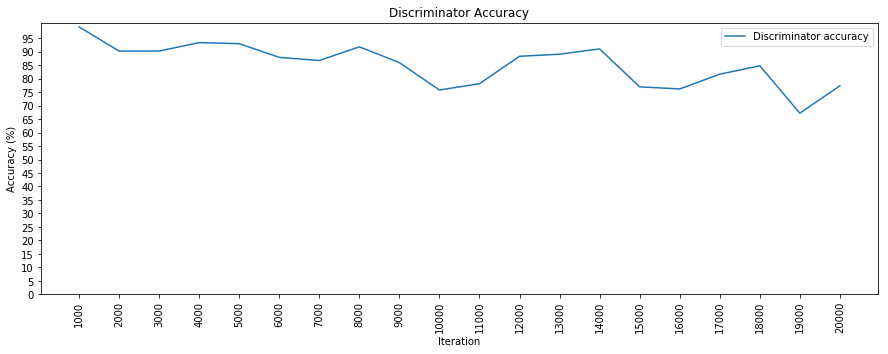

In [31]:
accuracies = np.array(accuracies)
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")
plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))
plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()